In [1]:
import os
import cv2
from skimage.feature import hog
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm

from scipy.fftpack import dct
from scipy.signal import convolve2d
from scipy import fftpack
from scipy.stats import skew, entropy as sc_entropy
from scipy.stats import entropy as sc_entropy

import pywt 
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2lab, rgb2gray
from skimage.filters import sobel, roberts
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.feature import local_binary_pattern
from skimage import feature, filters, util

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier



# Main Extraction

In [2]:
def fourier_features(gray_image):
    # Apply Fourier Transform
    fft_image = fftpack.fft2(gray_image)
    fft_magnitude = np.abs(fftpack.fftshift(fft_image))
    fft_phase = np.angle(fftpack.fftshift(fft_image))

    # Calculate features from the Fourier Transform
    fft_mean = np.mean(fft_magnitude)
    fft_std = np.std(fft_magnitude)
    fft_energy = np.sum(fft_magnitude ** 2)
    return {
        "fft_mean": fft_mean,
        "fft_std": fft_std,
        "fft_energy": fft_energy,
    }

def wavelet_features(gray_image):
    # Apply Wavelet Transform
    coeffs = pywt.dwt2(gray_image, 'haar')
    cA, (cH, cV, cD) = coeffs

    # Calculate features from the Wavelet Transform
    wavelet_mean = np.mean(cA)
    wavelet_std = np.std(cA)
    wavelet_energy = np.sum(np.square(cA))
    return {
        "wavelet_mean": wavelet_mean,
        "wavelet_std": wavelet_std,
        "wavelet_energy": wavelet_energy,
    }

def harris_corner_features(gray_image):
    gray = np.float32(gray_image)
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    dst = cv2.dilate(dst, None)

    # Threshold for an optimal value, it may vary depending on the image
    harris_corners = dst > 0.01 * dst.max()
    num_corners = np.sum(harris_corners)

    # Sum of Harris corner response values
    harris_formula_sum = np.sum(dst[harris_corners])

    # Calculate the variance of the corner positions
    corner_positions = np.argwhere(harris_corners)
    if len(corner_positions) > 0:
        corner_variance = np.var(corner_positions, axis=0)
    else:
        corner_variance = np.zeros(2)  # Default variance

    # Calculate the mean area of the corner points
    if num_corners > 0:
        corner_area_mean = np.mean(dst[harris_corners])
    else:
        corner_area_mean = 0.0

    # Calculate the mean length of the edges
    edge_lengths = np.sum(harris_corners, axis=1)
    if num_corners > 0:
        edge_length_mean = np.mean(edge_lengths)
    else:
        edge_length_mean = 0.0

    return {
        "num_corners": num_corners,
        "harris_formula_sum": harris_formula_sum,
        "corner_variance_x": corner_variance[1],  # Assuming x and y are flipped
        "corner_variance_y": corner_variance[0],  # Assuming x and y are flipped
        "corner_area_mean": corner_area_mean,
        "edge_length_mean": edge_length_mean
    }

def laplacian_of_gaussian(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)    # Apply Gaussian blur
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)    # Apply Laplacian operator
    return laplacian

In [ ]:
def load_images_and_labels(root_dir):
    images = []
    labels = []
    image_paths = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.JPEG', '.PNG', '.BMP')
    
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if any(file.endswith(ext) for ext in valid_extensions):
                img_path = os.path.join(subdir, file)
                label = os.path.basename(os.path.dirname(img_path))
                images.append(img_path)
                labels.append(label)
                image_paths.append(img_path)
    
    return images, labels, image_paths

def extract_color_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image not found at {image_path}")
        return None
    
    #################### Gray ####################
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #################### RGB ####################
    R, G, B = cv2.split(image)

    average_color_rgb = np.mean(image, axis=(0, 1))  # [R, G, B]
    R_avg, G_avg, B_avg = average_color_rgb
    R_sqrt = np.sqrt(R_avg)
    G_sqrt = np.sqrt(G_avg)
    B_sqrt = np.sqrt(B_avg)

    sum_colors_rgb = R_avg + G_avg + B_avg
    if sum_colors_rgb == 0:
        NRI = NGI = NBI = 0  # Avoid division by zero
    else:
        NRI = R_avg / sum_colors_rgb
        NGI = G_avg / sum_colors_rgb
        NBI = B_avg / sum_colors_rgb

    #################### HSV ####################
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    H, S, V = cv2.split(image_hsv)

    average_color_hsv = np.mean(image_hsv, axis=(0,1))
    H_avg, S_avg, V_avg = average_color_hsv
    H_sqrt = np.sqrt(H_avg)
    S_sqrt = np.sqrt(S_avg)
    V_sqrt = np.sqrt(V_avg)

    sum_colors_hsv = H_avg + S_avg + V_avg
    if sum_colors_rgb == 0:
        NHI = NSI = NVI = 0  
    else:
        NHI = H_avg / sum_colors_hsv
        NSI = S_avg / sum_colors_hsv
        NVI = V_avg / sum_colors_hsv
    # Calculate histograms with N bins for each channel
    n_bins = 64
    hist_hue = cv2.calcHist([image_hsv], [0], None, [n_bins], [0, 256]) 
    hist_hue1, hist_hue2, hist_hue3, hist_hue4, hist_hue5, hist_hue6, hist_hue7, hist_hue8, hist_hue9, hist_hue10, hist_hue11, hist_hue12, hist_hue13, hist_hue14, hist_hue15, hist_hue16, hist_hue17, hist_hue18, hist_hue19, hist_hue20, hist_hue21, hist_hue22, hist_hue23, hist_hue24, hist_hue25, hist_hue26, hist_hue27, hist_hue28, hist_hue29, hist_hue30, hist_hue31, hist_hue32, hist_hue33, hist_hue34, hist_hue35, hist_hue36, hist_hue37, hist_hue38, hist_hue39, hist_hue40, hist_hue41, hist_hue42, hist_hue43, hist_hue44, hist_hue45, hist_hue46, hist_hue47, hist_hue48, hist_hue49, hist_hue50, hist_hue51, hist_hue52, hist_hue53, hist_hue54, hist_hue55, hist_hue56, hist_hue57, hist_hue58, hist_hue59, hist_hue60, hist_hue61, hist_hue62, hist_hue63, hist_hue64 = hist_hue.flatten()
  
    hist_saturation = cv2.calcHist([image_hsv], [1], None, [n_bins], [0, 256])
    hist_saturation1, hist_saturation2, hist_saturation3, hist_saturation4, hist_saturation5, hist_saturation6, hist_saturation7, hist_saturation8, hist_saturation9, hist_saturation10, hist_saturation11, hist_saturation12, hist_saturation13, hist_saturation14, hist_saturation15, hist_saturation16, hist_saturation17, hist_saturation18, hist_saturation19, hist_saturation20, hist_saturation21, hist_saturation22, hist_saturation23, hist_saturation24, hist_saturation25, hist_saturation26, hist_saturation27, hist_saturation28, hist_saturation29, hist_saturation30, hist_saturation31, hist_saturation32, hist_saturation33, hist_saturation34, hist_saturation35, hist_saturation36, hist_saturation37, hist_saturation38, hist_saturation39, hist_saturation40, hist_saturation41, hist_saturation42, hist_saturation43, hist_saturation44, hist_saturation45, hist_saturation46, hist_saturation47, hist_saturation48, hist_saturation49, hist_saturation50, hist_saturation51, hist_saturation52, hist_saturation53, hist_saturation54, hist_saturation55, hist_saturation56, hist_saturation57, hist_saturation58, hist_saturation59, hist_saturation60, hist_saturation61, hist_saturation62, hist_saturation63, hist_saturation64 = hist_saturation.flatten()   
   
    hist_value = cv2.calcHist([image_hsv], [2], None, [n_bins], [0, 256])
    hist_value1, hist_value2, hist_value3, hist_value4, hist_value5, hist_value6, hist_value7, hist_value8, hist_value9, hist_value10, hist_value11, hist_value12, hist_value13, hist_value14, hist_value15, hist_value16, hist_value17, hist_value18, hist_value19, hist_value20, hist_value21, hist_value22, hist_value23, hist_value24, hist_value25, hist_value26, hist_value27, hist_value28, hist_value29, hist_value30, hist_value31, hist_value32, hist_value33, hist_value34, hist_value35, hist_value36, hist_value37, hist_value38, hist_value39, hist_value40, hist_value41, hist_value42, hist_value43, hist_value44, hist_value45, hist_value46, hist_value47, hist_value48, hist_value49, hist_value50, hist_value51, hist_value52, hist_value53, hist_value54, hist_value55, hist_value56, hist_value57, hist_value58, hist_value59, hist_value60, hist_value61, hist_value62, hist_value63, hist_value64 = hist_value.flatten()
  
    #################### Lab ####################
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    L, a, b = cv2.split(image_lab)
    average_color_lab = np.mean(image_lab, axis=(0, 1))
    L_avg, a_avg, b_avg = average_color_lab
    L_sqrt = np.sqrt(L_avg)
    a_sqrt = np.sqrt(a_avg)
    b_sqrt = np.sqrt(b_avg)
    sum_colors_Lab = L_avg + a_avg + b_avg
    if sum_colors_Lab == 0:
        NLI = NaI = NbI = 0  
    else:
        NLI = L_avg / sum_colors_Lab
        NaI = a_avg / sum_colors_Lab
        NbI = b_avg / sum_colors_Lab

    #################### YUV/YCrCb ####################
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    Y, U, v = cv2.split(image_yuv)
    average_color_yuv = np.mean(image_yuv, axis=(0, 1))
    Y_avg, U_avg, v_avg = average_color_yuv
    Y_sqrt = np.sqrt(Y_avg)
    U_sqrt = np.sqrt(U_avg)
    v_sqrt = np.sqrt(v_avg)

    sum_colors_YUV = Y_avg + U_avg + V_avg
    if sum_colors_YUV == 0:
        NYI = NUI = NvI = 0  
    else:
        NYI = Y_avg / sum_colors_YUV
        NUI = U_avg / sum_colors_YUV
        NvI = v_avg / sum_colors_YUV

    #################### brightness ####################
    brightness_rgb = np.mean(average_color_rgb)
    brightness_hsv = np.mean(average_color_hsv)
    brightness_lab = np.mean(average_color_lab)
    brightness_yuv = np.mean(average_color_yuv)
    
    features = {
        "mean_H": np.mean(H), "mean_S": np.mean(S), "mean_V": np.mean(V),
        "std_H": np.std(H), "std_S": np.std(S), "std_V": np.std(V),
        "H_sqrt": H_sqrt, "S_sqrt": S_sqrt, "V_sqrt": V_sqrt,
        "NHI": NHI, "NSI": NSI, "NVI": NVI,
        
        **{f"hist_hue{i}": locals()[f"hist_hue{i}"] for i in range(1, 65)},
        **{f"hist_saturation{i}": locals()[f"hist_saturation{i}"] for i in range(1, 65)},
        **{f"hist_value{i}": locals()[f"hist_value{i}"] for i in range(1, 65)},

        "mean_R": np.mean(R), "mean_G": np.mean(G), "mean_B": np.mean(B),
        "std_R": np.std(R), "std_G": np.std(G), "std_B": np.std(B),
        "R_sqrt": R_sqrt, "G_sqrt": G_sqrt, "B_sqrt": B_sqrt,
        "NRI": NRI, "NGI": NGI, "NBI": NBI,

        "mean_L": np.mean(L), "mean_a": np.mean(a), "mean_b": np.mean(b),
        "std_L": np.std(L), "std_a": np.std(a), "std_b": np.std(b),
        "L_sqrt": L_sqrt, "a_sqrt": a_sqrt, "b_sqrt": b_sqrt,
        "NLI": NLI, "NaI": NaI, "NbI": NbI,

        "mean_Y": np.mean(Y), "mean_U": np.mean(U), "mean_v": np.mean(v),
        "std_Y": np.std(Y), "std_U": np.std(U), "std_v": np.std(v),
        "Y_sqrt": Y_sqrt, "U_sqrt": U_sqrt, "v_sqrt": v_sqrt,
        "NYI": NYI, "NUI": NUI, "NvI": NvI,

        "brightness_rgb": brightness_rgb, "brightness_hsv": brightness_hsv,
        "brightness_lab": brightness_lab, "brightness_yuv": brightness_yuv,

        "mean_intensity": np.mean(gray_image), "std_intensity": np.std(gray_image)
    }
    
    return features

def extract_texture_features(gray_image):
    glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    # Entropy
    entropy_image = entropy(gray_image, disk(3))
    entropy_mean = entropy_image.mean()
    entropy_std = entropy_image.std()
    
    roberts_img = roberts(gray_image)
    roberts_mean = roberts_img.mean()
    roberts_std = roberts_img.std()
    sobel_img = sobel(gray_image)
    sobel_mean = sobel_img.mean()
    sobel_std = sobel_img.std()


    # Gabor 1
    kernel1 = cv2.getGaborKernel((9, 9), 3, np.pi/4, np.pi, 0.5, 0, ktype=cv2.CV_64F)
    gabor_mean1 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel1)).mean()
    gabor_std1 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel1)).std()
    # Gabor 2
    kernel2 = cv2.getGaborKernel((9, 9), 3, np.pi/2, np.pi/2, 0.9, 0, ktype=cv2.CV_64F)
    gabor_mean2 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel2)).mean()
    gabor_std2 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel2)).std()
    # Gabor 3
    kernel3 = cv2.getGaborKernel((9, 9), 3, np.pi/2, np.pi/2, 0.5, 0, ktype=cv2.CV_64F)
    gabor_mean3 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).mean() 
    gabor_std3 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).std() 
    #Gabor 4
    kernel4 = cv2.getGaborKernel((9, 9), 3, 0, np.pi, 1, 0, ktype=cv2.CV_64F)
    gabor_mean4 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).mean() 
    gabor_std4 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).std() 
    #Gabor 5
    kernel5 = cv2.getGaborKernel((9, 9), 5, np.pi/4, np.pi, 0.5, 0, ktype=cv2.CV_64F)
    gabor_mean5 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).mean() 
    gabor_std5 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).std() 
    #Gabor 6
    kernel6 = cv2.getGaborKernel((9, 9), 5, np.pi/2, np.pi/2, 0.5, 0, ktype=cv2.CV_64F)
    gabor_mean6 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).mean() 
    gabor_std6 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).std() 
    #Gabor 7
    kernel7 = cv2.getGaborKernel((11, 11), 3, np.pi/4, np.pi, 0.5, 0, ktype=cv2.CV_64F)
    gabor_mean7 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).mean() 
    gabor_std7 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).std() 
    #Gabor 8 
    kernel8 = cv2.getGaborKernel((11, 11), 3, np.pi/2, np.pi/2, 0.9, 0, ktype=cv2.CV_64F)
    gabor_mean8 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).mean() 
    gabor_std8 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).std() 
    #Gabor 9
    kernel9 = cv2.getGaborKernel((11, 11), 5, np.pi/4, np.pi, 0.5, 0, ktype=cv2.CV_64F)
    gabor_mean9 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).mean() 
    gabor_std9 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).std() 
    #Gabor 10
    kernel10 = cv2.getGaborKernel((11, 11), 5, np.pi/2, np.pi/2, 0.5, 0, ktype=cv2.CV_64F)
    gabor_mean10 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).mean() 
    gabor_std10 = (cv2.filter2D(gray_image, cv2.CV_8U, kernel3)).std() 

    #Canny
    canny_edges = feature.canny(gray_image)
    canny_edges_mean = canny_edges.mean()
    canny_edges_std = canny_edges.std()

    # Prewitt
    kernel_x = np.array([[-1, 0, 1],
                        [-1, 0, 1],
                        [-1, 0, 1]])

    kernel_y = np.array([[-1, -1, -1],
                        [0, 0, 0],
                        [1, 1, 1]])

    grad_x = cv2.filter2D(gray_image, -1, kernel_x)
    grad_y = cv2.filter2D(gray_image, -1, kernel_y)

    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2).astype(np.uint8)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    fft_features = fourier_features(gray_image)
    wavelet_features_dict = wavelet_features(gray_image)
    harris_features = harris_corner_features(gray_image)
    log_image = laplacian_of_gaussian(gray_image)
    log_mean = np.mean(log_image)
    log_std = np.std(log_image)
    
    texture_features = {
        "contrast": contrast,
        "homogeneity": homogeneity,
        "energy": energy,
        "correlation": correlation,
        "entropy": sc_entropy(gray_image.flatten()),
        "uniformity": np.mean(gray_image),
        "third_moment": skew(gray_image.flatten()),
        "entropy_mean": entropy_mean,
        "entropy_std": entropy_std,
        "roberts_mean": roberts_mean,
        "roberts_std": roberts_std,
        "sobel_mean": sobel_mean,
        "sobel_std": sobel_std,
        **{f"gabor_mean{i}": locals()[f"gabor_mean{i}"] for i in range(1, 11)},
        **{f"gabor_std{i}": locals()[f"gabor_std{i}"] for i in range(1, 11)},
        "gradient_magnitude_mean": gradient_magnitude.mean(),
        "gradient_magnitude_std": gradient_magnitude.std(),
        "lbp_mean": lbp_mean,
        "lbp_std": lbp_std,
        **fft_features,
        **wavelet_features_dict,
        **harris_features,
        "log_mean": log_mean,
        "log_std": log_std,
        "canny_edges_mean": canny_edges_mean,
        "canny_edges_std": canny_edges_std
    }
    
    return texture_features

def extract_shape_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h
    rect_area = w * h
    extent = float(area) / rect_area
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area
    
    shape_features = {
        "area": area,
        "perimeter": perimeter,
        "aspect_ratio": aspect_ratio,
        "extent": extent,
        "solidity": solidity,
        "length": max(w, h),
        "width": min(w, h),
        "length_to_width_ratio": max(w, h) / min(w, h),
        "convex_hull_area": hull_area,
        "convex_hull_perimeter": cv2.arcLength(hull, True),
        "major_axis_length": max(w, h),
        "minor_axis_length": min(w, h)
    }
    
    return shape_features


def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image not found at {image_path}")
        return None
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    color_features = extract_color_features(image_path)
    texture_features = extract_texture_features(gray_image)
    shape_features = extract_shape_features(image)
    all_features = {**color_features, **texture_features, **shape_features}
    return all_features

def save_features_to_csv(image_paths, labels, features, csv_file):
    data = []
    for img_path, label, feat in zip(image_paths, labels, features):
        row = [img_path, label] + list(feat.values())
        data.append(row)
    header = ["image_path", "label"] + list(features[0].keys())
    df = pd.DataFrame(data, columns=header)
    df.to_csv(csv_file, index=False)

if __name__ == "__main__":
    root_dir = "./Plant_leave_diseases_dataset_without_augmentation"
    image_paths, labels, _ = load_images_and_labels(root_dir)
    features = []
    for img_path in tqdm(image_paths, desc="Extracting features"):
        if img_path is not None:
            feat = extract_features(img_path)
            if feat is not None:
                features.append(feat)
    csv_file = 'final_extract.csv'
    save_features_to_csv(image_paths, labels, features, csv_file)
    #132 minutes to run

# Training Model

In [6]:
df = pd.read_csv("final_extract.csv")
df.head()

,image_path,label,mean_H,mean_S,mean_V,std_H,std_S,std_V,H_sqrt,S_sqrt,...,aspect_ratio,extent,solidity,length,width,length_to_width_ratio,convex_hull_area,convex_hull_perimeter,major_axis_length,minor_axis_length
0,./Plant_leave_diseases_dataset_without_augment...,Apple___Apple_scab,74.092346,91.905457,137.217667,61.114806,65.477788,19.793987,8.607691,9.586733,...,0.870293,0.595812,0.752429,239,208,1.149038,39364.5,756.184805,239,208
1,./Plant_leave_diseases_dataset_without_augment...,Apple___Apple_scab,79.182404,81.935562,123.372803,33.605701,46.302034,46.770438,8.898450,9.051826,...,0.991701,0.476302,0.726424,241,239,1.008368,37766.5,725.266126,241,239
2,./Plant_leave_diseases_dataset_without_augment...,Apple___Apple_scab,69.492859,87.851364,144.373978,37.748855,43.808006,33.855823,8.336238,9.372906,...,0.846473,0.394984,0.541984,241,204,1.181373,35829.5,744.328388,241,204
3,./Plant_leave_diseases_dataset_without_augment...,Apple___Apple_scab,84.509872,90.920059,90.358536,22.866967,30.043161,31.579684,9.192925,9.535201,...,0.667969,0.677175,0.779162,256,171,1.497076,38046.0,748.979286,256,171
4,./Plant_leave_diseases_dataset_without_augment...,Apple___Apple_scab,96.732620,71.022125,134.278290,38.115114,30.186687,29.183758,9.835274,8.427463,...,1.183168,0.745308,0.915084,239,202,1.183168,39321.0,755.614123,239,202


In [7]:

df = df.drop(columns=["image_path"])
columns_to_scale = [col for col in df.columns if col != 'label']
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
label = LabelEncoder()
df['label'] = label.fit_transform(df['label'])


In [8]:
mean_values = df.mean()
columns_to_drop = mean_values[mean_values == 0].index
df = df.drop(columns=columns_to_drop)


In [9]:
# SVC without ROS
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]
X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]

svm = SVC(C=100, gamma='scale', kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted') 

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
#9713

Accuracy: 0.9724
Precision: 0.9724
Recall: 0.9724
F1-score: 0.9724


In [10]:
# SVC with ROS
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]
X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
svm = SVC(C=100, gamma='scale', kernel='rbf', random_state=42)
svm.fit(X_train_resampled, y_train_resampled)

y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted') 
f1 = f1_score(y_test, y_pred, average='weighted') 
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
#9708


Accuracy: 0.9725
Precision: 0.9725
Recall: 0.9725
F1-score: 0.9724


In [11]:
# Logistic Regression
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]
X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]
log_reg = LogisticRegression(C=100, penalty='l2', solver='lbfgs', max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted')  

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9354
Precision: 0.9354
Recall: 0.9354
F1-score: 0.9353


In [12]:
#ET
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]
X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
et_classifier = ExtraTreesClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None
)
et_classifier.fit(X_train, y_train)
y_pred = et_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Extra Trees classifier accuracy: {accuracy:.4f}")
print(f"Extra Trees classifier precision: {precision:.4f}")
print(f"Extra Trees classifier recall: {recall:.4f}")
print(f"Extra Trees classifier F1-score: {f1:.4f}")

Extra Trees classifier accuracy: 0.9194
Extra Trees classifier precision: 0.9217
Extra Trees classifier recall: 0.8669
Extra Trees classifier F1-score: 0.8838


In [16]:
#XGB
n_loops = 5

accuracies = []
precisions = []
recalls = []
f1_scores = []



for i in range(n_loops):
    xgb_params = {
        'n_estimators': 1000,               
        'max_depth': 2,                   
        'learning_rate': 0.1,               
        'subsample': 0.8,                  
        'colsample_bytree': 0.8,           
        'gamma': 0.03,                        
        'reg_alpha': 0,                     # Giá trị alpha cho regularization L1
        'reg_lambda': 1,                    # Giá trị lambda cho regularization L2
        'min_child_weight': 1,           
        'random_state': 42,
        'n_jobs': -1   
    }

    xgb_clf = XGBClassifier(**xgb_params)

    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)


    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# Tính giá trị trung bình cho mỗi chỉ số
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")


Average Accuracy: 0.9723
Average Precision: 0.9723
Average Recall: 0.9723
Average F1-score: 0.9722


In [17]:
# KNN
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]
X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]

knn = KNeighborsClassifier(
    n_neighbors=3,           
    weights='distance',      # Possible values: 'uniform', 'distance', or a callable.
    algorithm='auto',        # Algorithm used to compute the nearest neighbors: 'auto', 'ball_tree', 'kd_tree', 'brute'.
    leaf_size=30,            # Leaf size passed to BallTree or KDTree. Affects speed of the construction and query.
    p=2,                     # Power parameter for the Minkowski metric. 1 = Manhattan (L1), 2 = Euclidean (L2).
    metric='manhattan',      # The distance metric to use. Default is 'minkowski'. Can use other metrics like 'manhattan', 'chebyshev'.
    n_jobs=-1                # The number of parallel jobs to run for neighbors search. -1 means using all processors.
)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted') 

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9246
Precision: 0.9251
Recall: 0.9246
F1-score: 0.9236


# Feature Selection

In [19]:
# RF
n_loops = 5
accuracies = []
precisions = []
recalls = []
f1_scores = []

for i in range(n_loops):
    train_data, test_data = train_test_split(df, test_size=0.3, random_state=42 + i)

    X_train = train_data.drop(columns=["label"])
    y_train = train_data["label"]
    X_test = test_data.drop(columns=["label"])
    y_test = test_data["label"]

    rf = RandomForestClassifier(
        n_estimators=500,     
        max_depth=None,     
        min_samples_split=2,  
        min_samples_leaf=1,  
        max_features='sqrt', 
        bootstrap=True,   
        random_state=42 + i,
        oob_score=True,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")


Average Accuracy: 0.9396
Average Precision: 0.9402
Average Recall: 0.9396
Average F1-score: 0.9381


In [20]:
import plotly.express as px

feature_importance = rf.feature_importances_
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
fig = px.bar(importance_df, x='feature', y='importance', title='Feature Importances', labels={'importance': 'Importance', 'feature': 'Feature'}, width=1200, height=800)
fig.show()


In [21]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
print(importance_df)

                     feature  importance
271          canny_edges_std    0.010013
270         canny_edges_mean    0.009567
207                    std_v    0.009538
16                 hist_hue5    0.009334
276                 solidity    0.009090
13                 hist_hue2    0.008860
22                hist_hue11    0.008662
21                hist_hue10    0.008641
206                    std_U    0.008601
6                     H_sqrt    0.008276
0                     mean_H    0.008127
263       harris_formula_sum    0.008058
194                    std_a    0.007632
14                 hist_hue3    0.007463
266         corner_area_mean    0.007433
17                 hist_hue6    0.007302
197                   a_sqrt    0.007118
191                   mean_a    0.007091
255                  lbp_std    0.007056
15                 hist_hue4    0.006992
224                  entropy    0.006992
57          hist_saturation2    0.006936
195                    std_b    0.006914
223             

In [46]:
threshold = 0.0035
important_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()

print(f"Number of important features: {len(important_features)}")

important_features.append("label")
filtered_data = df[important_features]

train_data, test_data = train_test_split(filtered_data, test_size=0.3, random_state=42)
X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]
X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]
#89

Number of important features: 112


In [47]:
# check shape of train feature
print(X_train.shape)

(38813, 112)


In [ ]:
# XGB with feature selection
n_loops = 5

accuracies = []
precisions = []
recalls = []
f1_scores = []



for i in range(n_loops):
    xgb_params = {
        'n_estimators': 1000,               
        'max_depth': 2,                   
        'learning_rate': 0.1,               
        'subsample': 0.8,                  
        'colsample_bytree': 0.8,           
        'gamma': 0.03,                        
        'reg_alpha': 0,                     # Giá trị alpha cho regularization L1
        'reg_lambda': 1,                    # Giá trị lambda cho regularization L2
        'min_child_weight': 1,           
        'random_state': 42,
        'n_jobs': -1   
    }

    xgb_clf = XGBClassifier(**xgb_params)
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")


Accuracy: 0.9740
Precision: 0.9741
Recall: 0.9740
F1-score: 0.9740
Confusion Matrix:


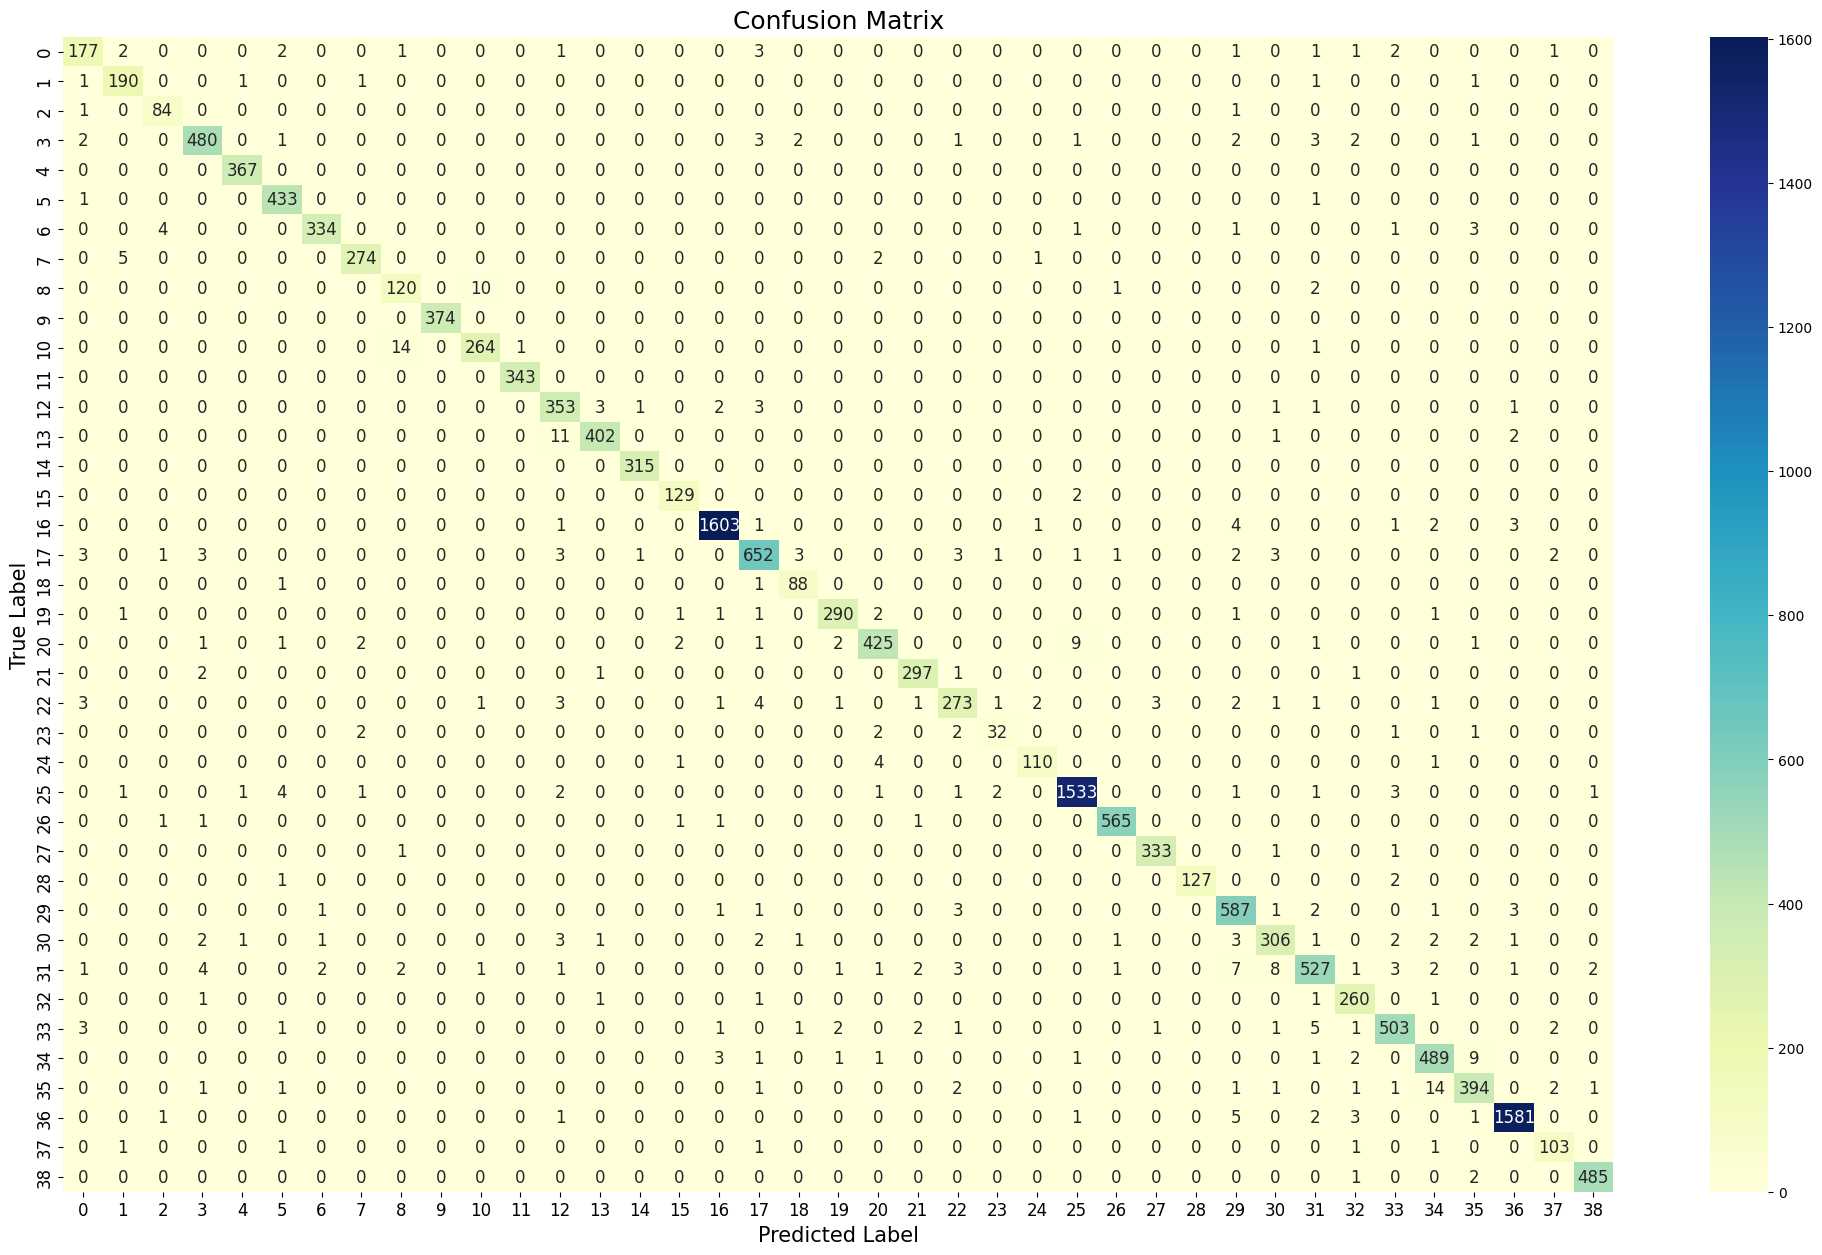

In [48]:
# SVC with feature selection
svm = SVC(C=100, gamma='scale', kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Adjusted for multiclass
recall = recall_score(y_test, y_pred, average='weighted')  # Adjusted for multiclass
f1 = f1_score(y_test, y_pred, average='weighted')  # Adjusted for multiclass
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")


# Vẽ confusion matrix
plt.figure(figsize=(25, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True, annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
#9713            #134 9737 #112 9740  #89 9702 

In [49]:
# Voting 

rf_clf = RandomForestClassifier(
    n_estimators=5,  # Reduced from 500
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None
)

bagging_rf = BaggingClassifier(estimator=rf_clf, n_estimators=5, random_state=42)  # Reduced from 10
bagging_svm = BaggingClassifier(estimator=SVC(C=100, gamma='scale', kernel='rbf', probability=True, random_state=42), n_estimators=5, random_state=42)  # Reduced from 10
bagging_knn = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto', metric='manhattan', n_jobs=-1), n_estimators=5, random_state=42)  # Reduced from 10
bagging_lr = BaggingClassifier(estimator=LogisticRegression(C=100, penalty='l2', solver='lbfgs', max_iter=10000, random_state=42), n_estimators=5, random_state=42)  # Reduced from 10

voting_clf = VotingClassifier(estimators=[
    ('rf', bagging_rf),
    ('svm', bagging_svm),
    ('knn', bagging_knn),
    ('lr', bagging_lr)
], voting='soft', n_jobs=1)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Soft Voting classifier accuracy: {accuracy:.4f}")
print(f"Soft Voting classifier precision: {precision:.4f}")
print(f"Soft Voting classifier recall: {recall:.4f}")
print(f"Soft Voting classifier F1 score: {f1:.4f}")

#9723

c:\Users\5530\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

c:\Users\5530\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

c:\Users\5530\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

c:\Users\5530\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

c:\Users\5530\AppData\Local\Programs\Python\

Soft Voting classifier accuracy: 0.9732
Soft Voting classifier precision: 0.9683
Soft Voting classifier recall: 0.9639
Soft Voting classifier F1 score: 0.9659
